 # MVPA Per Subject

In [1]:
import numpy as np
import nibabel as nb
import os

In [2]:
# define paths
root_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2"
# root_dir = "/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK2"  # sim01 dir

fmriprep_dir = os.path.join(root_dir, "derivatives", "fmriprep23")
dataset_dir = os.path.join(root_dir, "derivatives", "mvpa_08_stability_bold", "features_full")

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith("_features.npy") & f.startswith("sub-")]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith("_labels.npy") & f.startswith("sub-")]
label_files.sort()

In [4]:
# get number of subjects
n_runs_per_sub = 4
n_subjects = len(dataset_files) / n_runs_per_sub
print("Number of subjects found: %f" % n_subjects)

Number of subjects found: 20.000000


In [5]:
# estimate expected number of rows
# 20 subjects, 9 x 2 music for each of the 4 runs

n_music_trials = 9 * 2
n_music_splits = 4

n_rows_estimate_per_run = n_music_trials * n_music_splits
n_rows_estimate_per_sub = n_runs_per_sub * n_rows_estimate_per_run
n_rows_estimate = n_subjects * n_rows_estimate_per_sub
print(f"Estimated number of rows: {n_rows_estimate}")

Estimated number of rows: 5760.0


In [6]:
# generate an array of chunk labels
chunks = np.repeat(np.arange(1, n_runs_per_sub + 1), n_rows_estimate_per_run)
chunks.shape

(288,)

# Iteration

In [11]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from sklearn.svm import LinearSVC
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

n_classes = 9
class_names = ["JoyfulActivation", "Nostalgia", "Peacefulness", "Power", "Sadness", "Tenderness", "Tension", "Transcendence", "Wonder"]
n_folds = int(n_runs_per_sub)
n_subjects = int(n_subjects)
acc_array = np.zeros((n_subjects, n_folds))
acc_bal_array = np.zeros((n_subjects, n_folds))
confusion_matrix_array = np.zeros((n_subjects, n_classes, n_classes, n_folds))
acc_train_cv_array = np.zeros((n_subjects, n_folds))
c_train_cv_array = np.zeros((n_subjects, n_folds))
weights_list = []


def process_mvpa_sub(ss, chunks):
    print(f"subject {ss + 1}/{n_subjects}...")

    start_idx = (ss + 1 - 1) * n_runs_per_sub
    end_idx = n_runs_per_sub * (ss + 1)
    print(f"Selection from {start_idx} to {end_idx}")

    samples = np.concatenate([np.load(f) for f in dataset_files[start_idx:end_idx]], axis=0)
    labels = np.concatenate([np.load(f, allow_pickle=True) for f in label_files[start_idx:end_idx]], axis=0)

    c_train_cv = np.zeros(n_folds)
    acc_train_cv = np.zeros(n_folds)
    acc = np.zeros(n_folds)
    acc_bal = np.zeros(n_folds)
    cm = np.zeros((n_classes, n_classes, n_folds))
    weights = np.zeros((n_classes, samples.shape[1]))
    current_acc = 0

    for ff in range(n_folds):
        print(f"fold {ff + 1}/{n_folds}...")

        # split the data into training and test set
        train_mask = chunks != ff + 1
        test_mask = chunks == ff + 1

        X_train = samples[train_mask, :]
        y_train = labels[train_mask]
        X_test = samples[test_mask, :]
        y_test = labels[test_mask]

        # GridSearch + Training
        parameters = {"C": range(1, 21)}

        svc = LinearSVC(multi_class="ovr", max_iter=5000, class_weight="balanced", dual="auto")

        clf = GridSearchCV(svc, parameters, return_train_score=True, cv=3, n_jobs=3)

        clf.fit(X_train, y_train)

        # Store the best parameters
        c_train_cv[ff] = clf.best_params_["C"]
        acc_train_cv[ff] = clf.best_score_

        # Store the weights if the current model is better
        if clf.best_score_ > current_acc:
            weights = clf.best_estimator_.coef_
            current_acc = clf.best_score_

        # Testing
        y_pred = clf.best_estimator_.predict(X_test)

        # Compute the prediction accuracy for the different labels
        acc[ff] = (y_pred == y_test).mean()
        acc_bal[ff] = balanced_accuracy_score(y_test, y_pred)

        # confusion matrix
        cm[..., ff] = confusion_matrix(y_test, y_pred, normalize="true")

    return ss, acc, acc_bal, cm, acc_train_cv, c_train_cv, weights

In [12]:
# execute the process_fold function with the chunks argument
with ThreadPoolExecutor(max_workers=3) as executor:
    results = list(executor.map(process_mvpa_sub, range(int(n_subjects)), [chunks] * int(n_subjects)))

# sort by the first element of the tuple (the subject index)
results.sort(key=lambda x: x[0])

# Update the accuracy arrays with the results
for ss, acc, acc_bal, cm, acc_train_cv, c_train_cv, weights in results:
    acc_array[ss, :] = acc
    acc_bal_array[ss, :] = acc_bal
    confusion_matrix_array[ss, ...] = cm
    acc_train_cv_array[ss, :] = acc_train_cv
    c_train_cv_array[ss, :] = c_train_cv
    weights_list.append(weights)

subject 1/20...subject 2/20...
Selection from 4 to 8

Selection from 0 to 4
subject 3/20...
Selection from 8 to 12
fold 1/4...
fold 1/4...
fold 1/4...
fold 2/4...
fold 2/4...
fold 2/4...
fold 3/4...
fold 3/4...
fold 3/4...
fold 4/4...
fold 4/4...
fold 4/4...
subject 4/20...
Selection from 12 to 16
fold 1/4...
subject 5/20...
Selection from 16 to 20
fold 1/4...
subject 6/20...
Selection from 20 to 24
fold 1/4...
fold 2/4...
fold 2/4...
fold 2/4...
fold 3/4...
fold 3/4...
fold 3/4...
fold 4/4...
fold 4/4...
fold 4/4...
subject 7/20...
Selection from 24 to 28
fold 1/4...
subject 8/20...
Selection from 28 to 32
fold 1/4...
subject 9/20...
Selection from 32 to 36
fold 1/4...
fold 2/4...
fold 2/4...
fold 2/4...
fold 3/4...
fold 3/4...
fold 3/4...
fold 4/4...
fold 4/4...
fold 4/4...
subject 10/20...
Selection from 36 to 40
fold 1/4...
subject 11/20...
Selection from 40 to 44
fold 1/4...
subject 12/20...
Selection from 44 to 48
fold 1/4...
fold 2/4...
fold 2/4...
fold 2/4...
fold 3/4...
fold 3

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/

subject 19/20...
Selection from 72 to 76
fold 1/4...


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


subject 20/20...
Selection from 76 to 80
fold 1/4...


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fold 2/4...
fold 2/4...
fold 3/4...
fold 3/4...
fold 4/4...
fold 4/4...


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


fold 4/4...


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/

In [13]:
# save the results
import pickle

data_to_save = {
    "results": results,
    "acc_array": acc_array,
    "acc_bal_array": acc_bal_array,
    "confusion_matrix_array": confusion_matrix_array,
    "acc_train_cv_array": acc_train_cv_array,
    "c_train_cv_array": c_train_cv_array,
    "weights_list": weights_list,
}

# Save the data to a file
with open("results_mvpa_08.pkl", "wb") as file:
    pickle.dump(data_to_save, file)


# Load and visualize

In [12]:
import pickle

# Load the data from the file
with open("results_mvpa_08.pkl", "rb") as file:
    data_loaded = pickle.load(file)

# Access the variables
results = data_loaded["results"]
acc_array = data_loaded["acc_array"]
acc_bal_array = data_loaded["acc_bal_array"]
confusion_matrix_array = data_loaded["confusion_matrix_array"]
acc_train_cv_array = data_loaded["acc_train_cv_array"]
c_train_cv_array = data_loaded["c_train_cv_array"]
weights_list = data_loaded["weights_list"]

class_names = ["JoyfulActivation", "Nostalgia", "Peacefulness", "Power", "Sadness", "Tenderness", "Tension", "Transcendence", "Wonder"]


In [8]:
m_s = np.mean(np.mean(acc_array, 1)) * 100
s_s = np.std(np.mean(acc_array, 1)) * 100

m_b_s = np.mean(np.mean(acc_bal_array, 1)) * 100
s_b_s = np.std(np.mean(acc_bal_array, 1)) * 100

m_t = np.mean(np.mean(acc_train_cv_array, 1)) * 100  # training accuracy from grid search
s_t = np.std(np.mean(acc_train_cv_array, 1)) * 100

c_t = np.mean(np.mean(c_train_cv_array, 1))  # training C from grid search
s_c = np.std(np.mean(c_train_cv_array, 1))

In [9]:
print(f"Mean test accuracy across subs: {m_s:0.1f}% \u00b1 {s_s:0.1f}%")
print(f"Mean test balanced accuracy across subs: {m_b_s:0.1f}% \u00b1 {s_b_s:0.1f}%")
print(f"Mean grid CV training accuracy across subs: {m_t:0.1f}% \u00b1 {s_t:0.1f}%")
print(f"Mean grid CV training C parameter across subs: {c_t:0.1f} \u00b1 {s_c:0.1f}")

Mean test accuracy across subs: 48.5% ± 6.2%
Mean test balanced accuracy across subs: 48.5% ± 6.2%
Mean grid CV training accuracy across subs: 45.3% ± 5.3%
Mean grid CV training C parameter across subs: 1.1 ± 0.3


In [10]:
M = np.mean(np.mean(confusion_matrix_array, 3), 0) * 100

M_annot = []

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        aux = f"{M[i, j]:0.1f}%"
        M_annot.append(aux)

M_annot_plot = np.array(M_annot).reshape(M.shape)

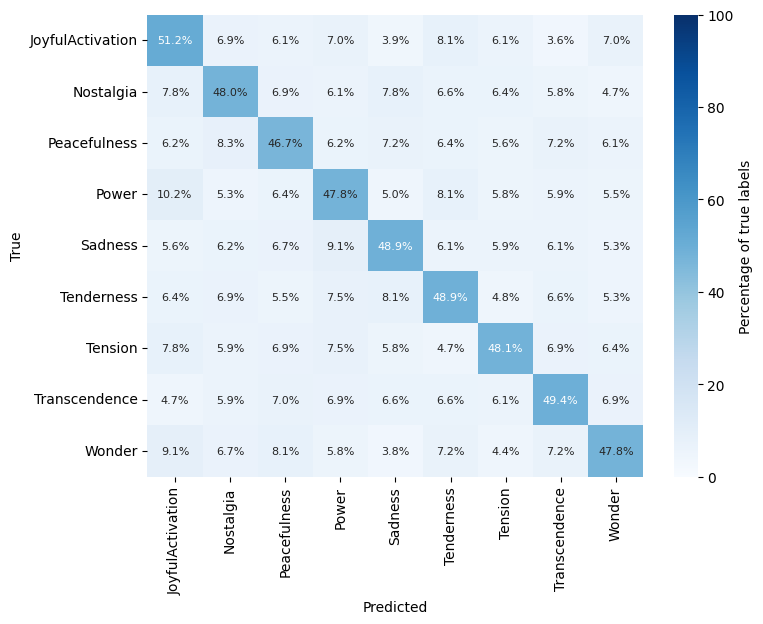

In [13]:
# | label: mvpa_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    M,
    annot=M_annot_plot,
    fmt="",
    cmap="Blues",
    vmin=0,
    vmax=100,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 8},
    cbar_kws={"label": "Percentage of true labels"},
)
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.title(f"Overall balanced accuracy = {m_s:0.1f}% \u00b1 {s_s:0.1f}%")
plt.show()